In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore") #The svr.predict always produces a warning.

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/oligomer-photostability-and-computed-properties/OligomerFeatures.csv


In [2]:
df = pd.read_csv("/kaggle/input/oligomer-photostability-and-computed-properties/OligomerFeatures.csv")
molecs = 40 #molecules with T80 values are listed at top of .csv
data_labels = np.array(df.columns.values[8:12]) #considering only the first 4 features to run quickly
all_features = np.array(df.iloc[:molecs,8:12])
T80 = np.array(df.iloc[:molecs,6])

#Scale X to unit variance and zero mean
st = StandardScaler()
X = st.fit_transform(all_features)
feats = X.shape[1]
y = T80

In [3]:
#Prep SVR Parameteres
C_reg = np.array([10,100,1000]) #reg. strength = 1/C_reg
#epsilon = np.array([0.1]) #points within this tube don't contribute to loss function

#Prep arrays
C_regs = C_reg.shape[0]
MSEs = np.zeros(C_regs)
R2s = np.zeros(C_regs)
top_y_pred = np.zeros((feats**2,molecs))
top_C_reg = np.zeros(feats**2)
top_R2s = np.zeros(feats**2)
out = "FeatA,FeatB,LOOV_R2,Creg\n"
All_R2s = np.zeros((feats,feats),dtype=float)

In [4]:
#Divide into train and test set for Leave One Out Validation with 2 Features per model
for k in range(feats):
    for l in range(k+1, feats):
        y_pred = np.zeros((C_regs, molecs))
        del_feats = np.arange(0, feats, dtype=int)
        del_feats = np.delete(del_feats, l, 0)
        del_feats = np.delete(del_feats, k, 0)
        X_temp = np.delete(X, del_feats, 1) #only 2 features
        for j in range(C_regs):
            for i in range(molecs):
                X_train = np.delete(X_temp,i,0)
                X_test = X_temp[i].reshape(1,-1)
                y_train = np.delete(y,i,0)
                
                svr = SVR(kernel="rbf", C=C_reg[j])
                svr.fit(X_train,y_train)
                #print(X_test)
                y_pred[j,i] = svr.predict(X_test) #gives NumPy Deprecation Warning
            MSEs[j] = mean_squared_error(y,y_pred[j])
            R2s[j]  = r2_score(y,y_pred[j])
        
        #Pick best model
        bestC = 0
        for i in range(len(MSEs)):
            if MSEs[i] < MSEs[bestC]:
                bestC = i

        top_y_pred[k*feats+l] = y_pred[bestC]
        top_C_reg[k*feats+l] = C_reg[bestC]
        top_R2s[k*feats+l] = R2s[bestC]
        All_R2s[k,l] = R2s[bestC]

        #print("{},{}, R2={:.2f}, Creg={:.0f}".format(data_labels[k],data_labels[l],R2s[bestC],C_reg[bestC]))
        out += "{},{},{:.4f},{:.0f}\n".format(data_labels[k],data_labels[l],R2s[bestC],C_reg[bestC])

In [5]:
#find the best features
bestF = np.argmax(top_R2s)
bestFeatA = int(np.floor(bestF/feats))
bestFeatB = bestF%feats

print("Best Model is {} + {}. R2 = {:.2f}".format(data_labels[bestFeatA],data_labels[bestFeatB],np.amax(top_R2s)))


Best Model is Mass + HDonors. R2 = 0.46


The "out" variable contains all results if you want to save all data to a csv.

In [6]:
fileo = open("SVR_LOOV_R2s.csv",'w')
fileo.write(out)
fileo.close()

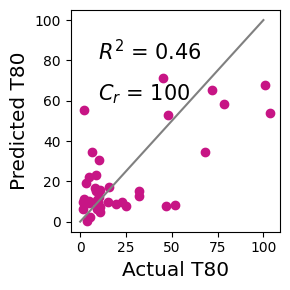

In [7]:
## Plot Best model performance ##
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(y, top_y_pred[bestF], color='mediumvioletred')
ax.plot([0,100],[0,100],color='gray')
ax.annotate("$R^2$ = {:.2f}".format(top_R2s[bestF]), xy=(10,80),size=15)
ax.annotate("$C_r$ = {:.0f}".format(top_C_reg[bestF]), xy=(10,60),size=15)
ax.set_ylabel("Predicted T80",fontsize='x-large');
ax.set_xlabel("Actual T80",fontsize='x-large');
fig.tight_layout()
#fig.savefig("TopFeaturePerformance_{}.png".format(bestF))
#plt.close()